# NOTE: BEFORE YOU GET STARTED

PLEASE DOWNLOAD MODEL ON [THIS](https://drive.google.com/open?id=1sNxVcRetWVZN_8fuZov7UQs7vuQm2L52) LINK (~100MB), EXTRACT ALL FILES TO `results` FOLDER

WE'VE PUT COMMENTS ON PACKAGES LIKE `hunspell` WHICH RUN ONLY DURING PREPROCESSING! SINCE YOU DOWNLOADED ALL FILES, RUNNING THIS CODE WILL JUST READ THE FILES, THAT ALREADY CONTAIN PROCESSED WORDS.

#### 0. Code we used to download dataset.

No need to run this since, models are already saved :)

In [ ]:
# 'Amazon_Instant_Video', 
# 'Apps_for_Android', 
# 'Automotive', 
# 'Baby', 
# 'Beauty', 
# 'Digital_Music', 
# 'Grocery_and_Gourmet_Food', 
# 'Health_and_Personal_Care', 
# 'Home_and_Kitchen', 
# 'Kindle_Store'

#DOWLOAD DATASETS

## UNCOMMENT to test :)
#!python Download_files.py -f amvi apps auto baby beau dgmu food heal hmkt kind  -dt r

### 1. Import all packages

In [21]:
from gensim.test.utils import common_texts,datapath
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel
from gensim import corpora 
from gensim.matutils import Sparse2Corpus, Scipy2Corpus
import pandas as pd
import numpy as np
import gzip
import re
import string
import os
from tqdm import tqdm_notebook
from time import time
# from hunspell import HunSpell # Installing this caused a lot of hassle
from multiprocessing import pool
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter
from gensim.parsing.porter import PorterStemmer
import pickle
import nltk
from joblib import Parallel, delayed
from gensim.corpora import MmCorpus
from gensim.models import TfidfModel
from sklearn.feature_extraction.text import TfidfTransformer
from itertools import chain
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA_sk
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.decomposition import PCA
sns.set()


nltk.download('stopwords')

# spellchecker = HunSpell('dicts_hun/en_US.dic',
#                         'dicts_hun/en_US.aff')

stemmer = PorterStemmer()

names = ['Amazon_Instant_Video', 
         'Apps_for_Android', 
         'Automotive', 
         'Baby', 
         'Beauty', 
         'Digital_Music', 
         'Grocery_and_Gourmet_Food', 
         'Health_and_Personal_Care', 
         'Home_and_Kitchen', 
         'Kindle_Store'
        ]

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

W0321 19:13:02.479192 140407962191680 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Word preprocessing! It doesn't take a lot of time, if files in `results` folder exists, preprocessing won't be run again and files will be loaded!

1. Datasets are loaded (this is **SLOW**, but parallized! You can set number of cores with `paralelize_reading`. TAKES A LOT OF **RAM**)
2. `n` comments are randomly chosen
3. Remove punctionation and digits
4. Remove STOP words 'he', 'she', 'is' etc.
5. Remove wrongly spelled words (we thought of spelling them correctly, but it slows process 50x times!)
6. Stemming! `stemmer.stem('ponies') -> 'poni`
7. Remove rare words
8. Create dictionary, vocabulary, corpus and SAVE THEM!

In [2]:
force_rerun_preprocessing = 0 ## If you want run code again even if files exist
paralelize_reading = 12 ## Number of cores used for reading, set to 1 if you don't want to paralelize

def read_dataset(name):
    df = getDF('data/reviews/reviews_{}.json.gz'.format(name))
    print('Reading {} finished!'.format(name))
    return df.reviewText + ' ' + df.summary + ' '
    

if ((os.path.isfile('results/corpus.pickle') and 
    os.path.isfile('results/dictionary.pickle') and
    os.path.isfile('results/vocab.pickle')) and not(force_rerun_preprocessing)):
    
    with open('results/corpus.pickle', 'rb') as f:
        corpus = pickle.load(f)
    with open('results/dictionary.pickle', 'rb') as f:
        dictionary = pickle.load(f)
    with open('results/vocab.pickle', 'rb') as f:
        vocabulary = pickle.load(f)
        
    print('Files already exist! No need to load this again!')
else:

    ans = ''

#     for name in tqdm_notebook(names):

#         df = getDF('data/reviews/reviews_{}.json.gz'.format(name))
#         ans += df.reviewText + ' ' + df.summary + ' '

    ## Let's use those cores :p
    print('Reading datasets')
    array_ans = Parallel(n_jobs=paralelize_reading)(delayed(read_dataset)(name) for name in names)
    
    for temp in array_ans:
        ans+=temp

    n = 50000

    re_punctuation = re.compile('['+string.punctuation+']')
    tokenizer = RegexpTokenizer('\w+')
    stop = stopwords.words('english')
    preprocessed_comments = []
    for comment in tqdm_notebook(np.random.choice(ans, n)):
        comment = re_punctuation.sub(' ', comment)
        comment = tokenizer.tokenize(comment)
        comment = [x for x in comment if not any(c.isdigit() for c in x)]
        comment = [word for word in comment if word not in stop]
        comment = [stemmer.stem(x) for x in comment if spellchecker.spell(x)]
        comment = [x for x in comment if len(x) > 3]
        preprocessed_comments.append(comment)
    
    
    wordFrequency = Counter()
    for comment in tqdm_notebook(preprocessed_comments):
        wordFrequency.update(comment)                                  # Count overall word frequency
    print('Unique Words In Comments: {}'.format(len(wordFrequency)))

    minimumWordOccurrences = 5
    # Remove rare words
    print('Removing rare words... ')
    texts = [[word for word in comment if wordFrequency[word] > minimumWordOccurrences] for comment in tqdm_notebook(preprocessed_comments)]

    print('Creating vocabulary...')
    dictionary = corpora.Dictionary(texts)                             # Create word dictionary
    vocabulary = [dictionary[i] for i in tqdm_notebook(dictionary.keys())]
    print('Documents/Comments: {}'.format(len(texts)))

    print('Creating corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in tqdm_notebook(preprocessed_comments)] # Create corpus

    
    print('Saving files...')
    with open('results/corpus.pickle', 'wb') as f:
        pickle.dump(corpus, f)
    with open('results/dictionary.pickle', 'wb') as f:
        pickle.dump(dictionary, f)
    with open('results/vocab.pickle', 'wb') as f:
        pickle.dump(vocabulary, f)
    
    print('WE ARE GOOD TO GO!')

Files already exist! No need to load this again!


### GENSIM LDA

#### Training is computationaly heavy and can take up to 5 hours, this has been processed on AWS EC2 cluster.
Note: If models exist in `results` folder, training won't run again and already existing model will be loaded.
You can freely run this cell.

In [3]:
force_rerun_lda = 0

if (os.path.isfile('results/model_gensim/model_gensim.model') & (not force_rerun_lda)):
    model_gensim = LdaMulticore.load("results/model_gensim/model_gensim.model", mmap='r')
    with open('results/model_gensim/perp_gensim.pickle', 'rb') as f:
        perp_gensim = pickle.load(f)
    with open('results/model_gensim/time_gensim.pickle', 'rb') as f:
        time_gensim = pickle.load(f)
else:
    numberTopics = 50  #Number of topics
    model_gensim = LdaMulticore(num_topics=numberTopics,
                            id2word=dictionary,
                            iterations=10,
                            passes=1,
                            chunksize=50,
                            eta='auto',
                            workers=12)

    
    perp_gensim = []
    times_gensim = []
    i=0
    max_it = 5
    min_prep = np.inf
    start = time()
    for _ in tqdm_notebook(range(100)):
        model_gensim.update(corpus)
        tmp = np.exp(-1 * model_gensim.log_perplexity(corpus))
        perp_gensim.append(tmp)
        times_gensim.append(time() - start)
        if(tmp<min_prep):
            min_prep = tmp;
            i = 0
        else:
            i = i + 1;
            if (i==max_it):
                break                # if prep increase for max_it number it will break the update procedure 
    model_gensim.save('results/model_gensim/model_gensim.model')
    with open('results/model_gensim/perp_gensim.pickle', 'wb') as f:
        pickle.dump(perp_gensim, f)
    with open('results/model_gensim/time_gensim.pickle', 'wb') as f:
        pickle.dump(times_gensim, f)
    

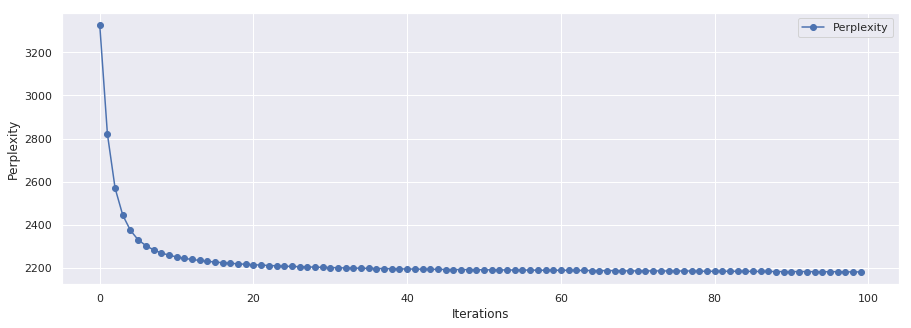

In [19]:
plt.figure(figsize=[15,5])
plt.plot(perp_gensim,'-o', label='Perplexity')
plt.xlabel('Iterations')
plt.ylabel('Perplexity')
plt.legend();

## GENERATED TOPICS

In [4]:
for i, topic in enumerate(model_gensim.get_topics().argsort(axis=1)[:, -10:][:, ::-1], 1):
    print('Topic {}: {}'.format(i, ' '.join([vocabulary[id] for id in topic])))

Topic 1: game love plai great like time gift well good christma
Topic 2: cream chees honei make snack freez freezer fridg food love
Topic 3: diaper cloth wipe wash towel pocket like great size chang
Topic 4: instal engin part mile replac truck bolt vehicl scale work
Topic 5: kindl fire version mirror great edit work like good page
Topic 6: filter crib sheet mattress great good like chang would bumper
Topic 7: night sleep back pillow time great like babi help love
Topic 8: plastic dryer metal piec tool made design blow part rubber
Topic 9: open door gate instal screw mount hole wall lock easi
Topic 10: film movi mani peopl histori make inform also would american
Topic 11: sauc spice salt pepper wine oliv spici garlic flavor tomato
Topic 12: cover video look tape like well hitch trailer jeep protect
Topic 13: hair product like shampoo great iron work look good love
Topic 14: bread bake recip cooki make cake pasta gluten free machin
Topic 15: teeth brush chew mouth head toothbrush tooth o

### PCA AND EMBEDDINGS VISUALIZATIONS


In [25]:
force_run_embedding = 0


embeddings = {}

if os.path.isfile('results/pca_amazon_comp.pickle') & \
   os.path.isfile('results/vocab_embeddings.pickle') & (not force_run_embedding):
    
    with open('results/vocab_embeddings.pickle', 'rb') as f:
        embeddings = pickle.load(f)
    with open('results/pca_amazon_comp.pickle', 'rb') as f:
        comp = pickle.load(f)
        

else:
    with tf.Session() as session:
        
        module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" 
        embed = hub.Module(module_url)
        tf.logging.set_verbosity(tf.logging.ERROR)
        
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        words_embeddings = session.run(embed(vocabulary))

        for i, words_embedding in tqdm_notebook(enumerate(np.array(words_embeddings).tolist())):
            embeddings[vocabulary[i]] = words_embedding
        
        emb = np.array([embeddings[key] for key in embeddings.keys()])
        pca = PCA(n_components=2)
        pca.fit(emb)
        comp = pca.components_   
        
        with open('results/vocab_embeddings.pickle', 'wb') as f:
            pickle.dump(embeddings, f)
        with open('results/pca_amazon_comp.pickle', 'wb') as f:
            pickle.dump(comp, f)
            
            

In [34]:
n_top_topics = [0, 2, 14, 19]
n_top_words = 12

topics_pca=[]
for i, topic in enumerate(model_gensim.get_topics().argsort(axis=1)[:, -n_top_words-1:][:, ::-1]):
    if i in n_top_topics:
        topics_pca.append([vocabulary[id] for id in topic if vocabulary[id] in embeddings.keys()])
#         print(topics_pca[-1])
topics_pca = np.array(topics_pca)

In [35]:
topics_components = []
for i, topic in enumerate(model_gensim.get_topics().argsort(axis=1)[:, -n_top_words-1:][:, ::-1]):
    if i in n_top_topics:
        topics_components.append(np.array([[np.array(embeddings[vocabulary[id]]).dot(component) for component in comp] for id in topic if vocabulary[id] in embeddings.keys()]))
#         print(topics_components[-1])
topics_components = np.array(topics_components)

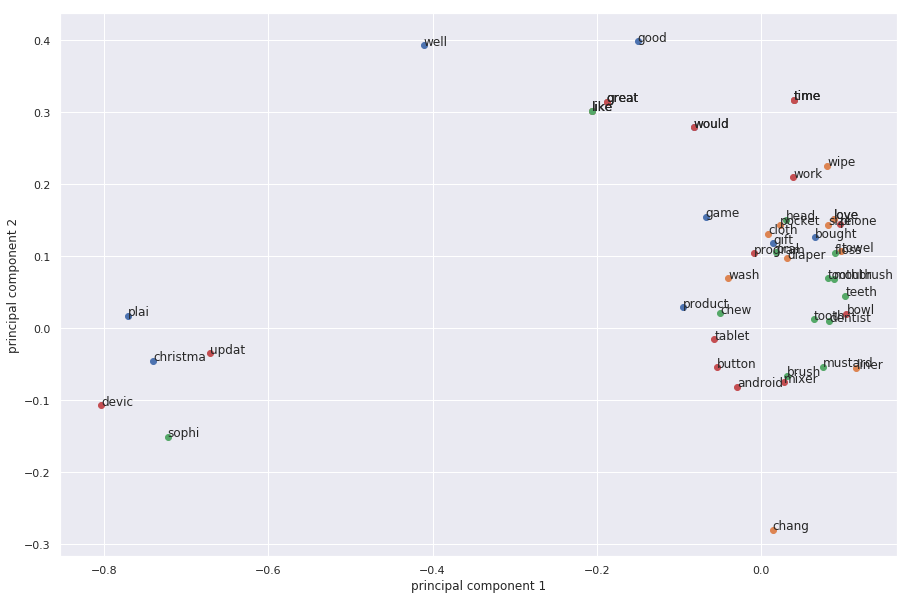

In [90]:
plt.figure(figsize=(15, 10))
for i, topic_components in enumerate(topics_components):
    plt.scatter(topic_components[:, 0], topic_components[:, 1])
    for txt, point in zip(topics_pca[i], topic_components):
        plt.annotate(txt, point)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2');
plt.savefig('pca.png')

### WORD CLOUDS

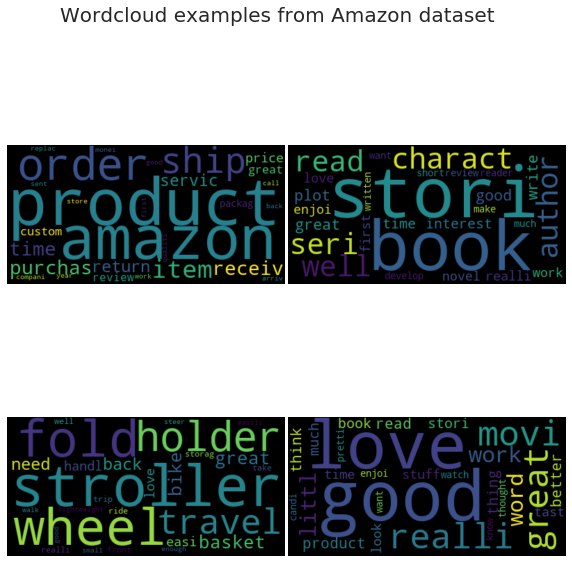

In [88]:
from wordcloud import WordCloud

word_cloud_arr = []

for i in range(4):
    
    for j in range(len(model_gensim[corpus[i]])):
        if j > 2:
            break
        topic = sorted(model_gensim[corpus[i+2]], key=lambda x: x[1], reverse=True)[j]
        wordcloud = WordCloud().generate(" ".join([item[0] for item in model_gensim.show_topic(topic[0], topn=30)]))
        word_cloud_arr.append(wordcloud)

f, axes = plt.subplots(2, 2, figsize=(10,10))

axes = axes.flatten()

for i in range(4):
    axes[i].imshow(word_cloud_arr[i], interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    
    
plt.subplots_adjust(wspace=.01, hspace=0)
    


plt.suptitle('Wordcloud examples from Amazon dataset', size=20);
        